In [ ]:
#  Popularity based systems (가장 높게 평가된 아이템을 추천하는 방식)

In [ ]:
# Surprise 설치
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 25.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619403 sha256=2a2fe58bbc73ba121f549ecb84607c0a202dc69083a916b600774406683a5a8c
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# 데이터 불러오기
ratings=pd.read_csv("./drive/MyDrive/data-files/ratings1.csv")
ratings.columns=['userId','movieId','rating','timestamp']
ratings.sort_values(by=['userId','movieId'], inplace=True)
ratings.head()
ratings.shape

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


(199999, 4)

In [ ]:
ratings.head()

In [ ]:
ratings = ratings.iloc[:1048576,0:]
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [ ]:
ratings.describe()['rating'].T

count    199999.000000
mean          3.566413
std           1.046466
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
print("max of rating : %d" %(ratings.rating.max()))
print("min of rating : %d" %(ratings.rating.min()))

max of rating : 5
min of rating : 0


In [ ]:
print('Number of missing values across columns: \n',ratings.isnull().sum())

Number of missing values across columns: 
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


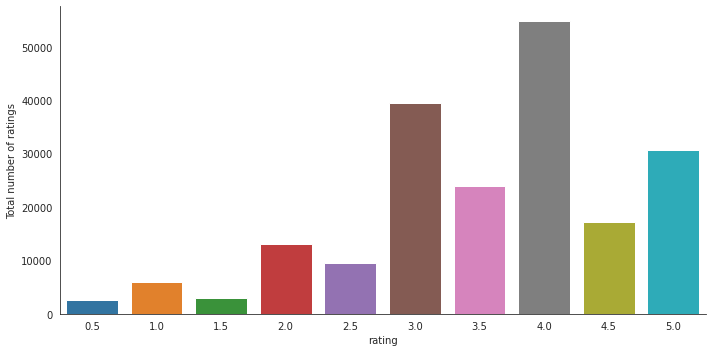

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data  = ratings, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings :", ratings.shape[0])
print("Total num of Users :", len(np.unique(ratings.userId)))
print("Total num of movie: ", len(np.unique(ratings.movieId)))

Total data
--------------------------------------------------

Total num of ratings : 199999
Total num of Users : 1409
Total num of movie:  12909


In [ ]:
num_of_rated_products_per_user = ratings.groupby(by = 'userId')['rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
548     3212
847     2920
997     2371
626     1888
1401    1531
Name: rating, dtype: int64

In [ ]:
num_of_rated_products_per_user.describe()

count    1409.000000
mean      141.943932
std       221.303657
min        20.000000
25%        36.000000
50%        68.000000
75%       160.000000
max      3212.000000
Name: rating, dtype: float64

In [ ]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles

0.00      20
0.01      20
0.02      20
0.03      20
0.04      21
        ... 
0.96     550
0.97     618
0.98     707
0.99    1067
1.00    3212
Name: rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

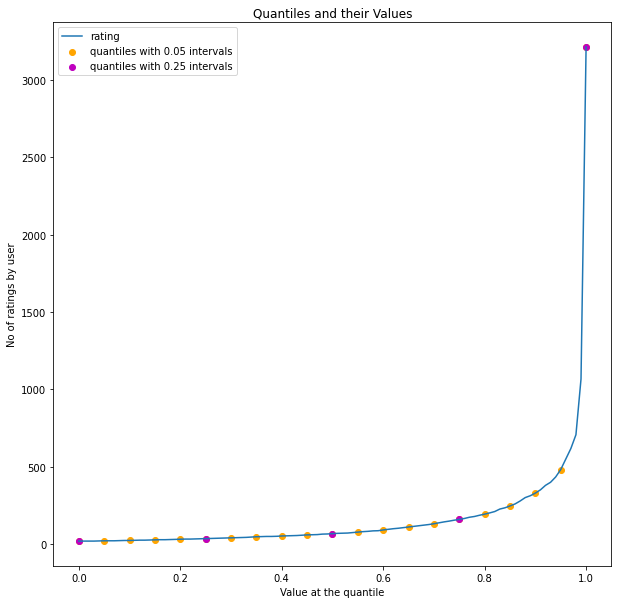

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated movie more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated movie more than 50 per user : 888



In [ ]:
new_df=ratings.groupby("movieId").filter(lambda x:x['rating'].count() >=50)
new_df.head()
new_df.shape

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
4,1,899,3.5
5,1,1088,4.0


(123436, 3)

Text(0.5, 1.0, '# RATINGS per Movie')

Text(0.5, 0, 'Movie')

Text(0, 0.5, 'No of ratings per movie')

[]

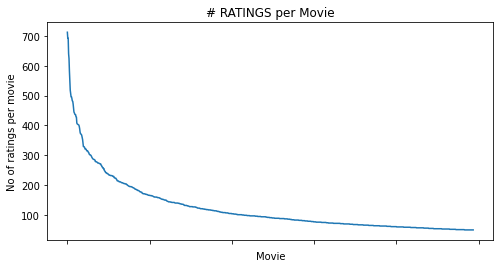

In [ ]:
num_of_ratings_per_movie = new_df.groupby(by='movieId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings per movie')
ax.set_xticklabels([])

In [ ]:
new_df.groupby('movieId')['rating'].mean().head()

movieId
1    3.960499
2    3.384393
3    3.267544
5    3.272277
6    3.797561
Name: rating, dtype: float64

In [ ]:
new_df.groupby('movieId')['rating'].mean().sort_values(ascending=False).head()

movieId
318     4.432803
858     4.370413
50      4.369295
1221    4.339416
527     4.292471
Name: rating, dtype: float64

In [ ]:
new_df.groupby('movieId')['rating'].count().sort_values(ascending=False).head()

movieId
356     712
296     692
318     692
593     640
2571    624
Name: rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('movieId')['rating'].mean())
ratings_mean_count.head()

,rating
movieId,
1,3.960499
2,3.384393
3,3.267544
5,3.272277
6,3.797561


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('movieId')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
movieId,,
1,3.960499,481
2,3.384393,173
3,3.267544,114
5,3.272277,101
6,3.797561,205


In [ ]:
ratings_mean_count['rating_counts'].max()

712

<Figure size 432x432 with 0 Axes>

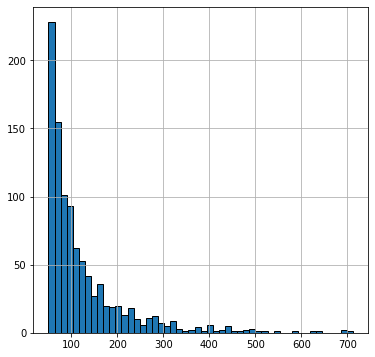

In [ ]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

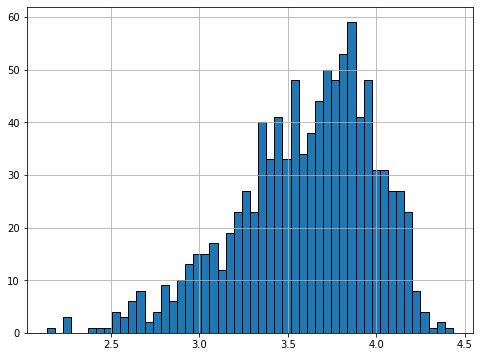

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

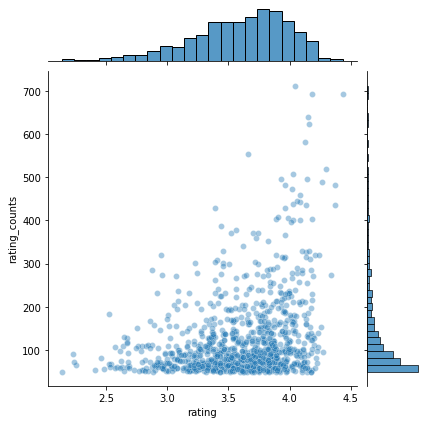

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

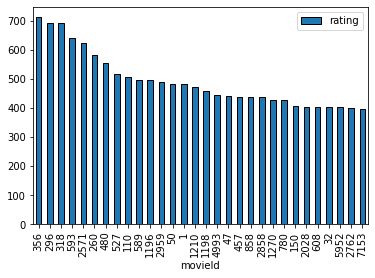

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('movieId')['rating'].count())
most_popular = popular_products.sort_values("rating", ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df,reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state=42)

In [ ]:
algo = KNNWithMeans(k=5, sim_options = {'name': 'pearson_baseline', 'user_based':False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(testset)
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.8364


0.8364182768698416

In [ ]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values ='rating', index ='userId', columns ='movieId',fill_value =0)
ratings_matrix.head()
ratings_matrix.shape

movieId,1,2,3,5,6,7,10,11,16,17,18,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,62,70,95,100,104,105,110,111,112,141,145,...,105844,106100,106487,106489,106696,106782,106920,108932,109374,109487,110102,111362,111759,112183,112552,112556,112852,115149,115569,115617,115713,116797,116823,119145,122882,122886,122892,122900,122904,122918,122920,134130,134853,139385,142488,148626,152081,164179,166528,168252
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0
2,3.5,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.5,0.0,0,0,0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0
3,4.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,4.5,0.0,4.5,0.0,0.0,0.0,0,0,0.0,0.0,5.0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,4.0,3,3.5,0.0,4.5,4,4.0,4.0,4.0,4.0,4,4.0,0.0,5.0,5.0,4.0,0.0,4.0,4.0,4.5,4.0,3.5,0.0,3.5,3.0,3.5,4.0,0.0,4.0,3.5,4.0,4,4,0.0,4.0,0.0,4.0,4,4.0
4,3.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1.5,0.0,0.0,0,3.5,4.5,5.0,3.5,0,4.0,0.0,4.5,0.0,3.0,4.0,5.0,3.5,5.0,0.0,2.0,4.5,5.0,2.0,0.0,0.0,3.5,3.0,0.0,4.0,0,5,0.0,4.0,4.5,5.0,4,0.0
5,4.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,4.0,0.0,0.0,0,0,0.0,0.0,5.0,0.0,5.0,2.0,0,0,5.0,0.0,5.0,0,0.0,0.0,0.0,3,0,4,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0


(120, 983)

In [ ]:
X = ratings_matrix.T
X.head()
X.shape

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,0.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


(983, 120)

In [ ]:
X.index

Int64Index([     1,      2,      3,      5,      6,      7,     10,     11,
                16,     17,
            ...
            122920, 134130, 134853, 139385, 142488, 148626, 152081, 164179,
            166528, 168252],
           dtype='int64', name='movieId', length=983)

In [ ]:
X1 = X
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(983, 10)

In [ ]:
decomposed_matrix

array([[14.22255285,  2.43479339,  5.02475632, ..., -4.69008383,
        -2.66452008,  1.82728079],
       [ 4.94470462, -2.08981227,  0.46153871, ...,  0.19315579,
        -0.61731102,  1.34424402],
       [ 3.59822032, -2.41822392, -2.14163795, ..., -2.51393957,
         0.35046634, -0.69436993],
       ...,
       [ 2.1161105 ,  3.32436784,  1.44799263, ...,  0.3157722 ,
        -1.19536854,  0.71838227],
       [ 1.65299334,  2.78963958,  1.07217907, ...,  0.1739216 ,
        -0.65575336,  0.05165467],
       [ 2.24852893,  2.96358227,  0.13637039, ...,  0.4500269 ,
         0.10689221, -0.27334503]])

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(983, 983)

In [ ]:
X.index[75]

253

In [ ]:
i = X.index[75]

product_names = list(X.index)
product_ID = product_names.index(i) #index구하기
product_ID

75

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(983,)

In [ ]:
correlation_product_ID

array([ 6.17889254e-01,  4.30436640e-01,  4.34755044e-01,  4.64466354e-01,
        4.89095923e-01,  4.49237282e-01,  9.48792775e-01,  4.72473270e-01,
        7.25954593e-01,  5.05987797e-01,  8.03471050e-01,  6.53595980e-01,
        8.20440632e-01,  6.43994230e-01,  2.96819605e-01,  6.70370153e-01,
        4.20161182e-01,  4.76285379e-01,  8.04948497e-01,  4.39244632e-01,
        5.29084189e-01,  7.20760691e-01,  4.34277341e-01,  5.93983713e-01,
        7.58714154e-01,  3.25996448e-01,  6.90468935e-01,  2.66198482e-01,
        4.34216469e-01,  5.12822457e-01,  4.26175510e-01,  8.48573650e-01,
        2.36270625e-01,  5.37444677e-01,  2.40257382e-01,  6.75431457e-01,
        3.26957387e-01,  6.51891296e-01,  8.60794877e-01,  8.71492259e-01,
        7.15263544e-01,  4.97260316e-01,  8.20294502e-01,  4.29620846e-01,
        9.24466354e-01,  6.07944795e-01,  6.81740903e-01,  9.12758186e-01,
        7.51200545e-01,  6.14771013e-01,  2.22179924e-01,  4.57252416e-01,
        2.86599936e-01,  

In [1]:
Recommend = list(X.index[correlation_product_ID > 0.65]) #피어슨 상관계수가 0.65보다 큰 영화들의 index의 list return

Recommend.remove(i) # 이미 본 영화는 뺀다

Recommend[0:10] #상위 10개 추천

NameError: ignored